# 주식 데이터 예측 (LSTM)
### 데이터 수집

In [195]:
import yfinance as yf
from datetime import date, timedelta

today = date.today()
end_date = today.strftime("%Y-%m-%d")

start = today - timedelta(days=365*5)
start_date = start.strftime("%Y-%m-%d")

print(start_date, end_date)

2020-02-19 2025-02-17


In [196]:
data = yf.download(
    tickers = "035420.KS",
    start = start_date,
    end = end_date
)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,035420.KS,035420.KS,035420.KS,035420.KS,035420.KS
Date,,,,,
2020-02-19,187005.437500,188485.691623,182564.675132,185525.183377,560743
2020-02-20,187498.859375,188979.113528,185031.769120,187005.441324,427402
2020-02-21,187005.437500,188485.691623,184538.347296,185031.765336,434019
2020-02-24,181577.828125,185031.754203,181084.410114,183058.082159,567036
2020-02-25,187992.265625,188485.683645,181084.413345,181577.831365,704859


In [197]:
data = data.iloc[:, 0:4]
data

Price,Close,High,Low,Open
Ticker,035420.KS,035420.KS,035420.KS,035420.KS
Date,,,,
2020-02-19,187005.437500,188485.691623,182564.675132,185525.183377
2020-02-20,187498.859375,188979.113528,185031.769120,187005.441324
2020-02-21,187005.437500,188485.691623,184538.347296,185031.765336
2020-02-24,181577.828125,185031.754203,181084.410114,183058.082159
2020-02-25,187992.265625,188485.683645,181084.413345,181577.831365
...,...,...,...,...
2025-02-10,227500.000000,232000.000000,227000.000000,229500.000000
2025-02-11,228500.000000,231500.000000,225500.000000,227500.000000


### 데이터 전처리

In [198]:
train_ratio = 0.7
train_size = int(data.shape[0] * train_ratio)
print(train_size)

857


In [199]:
seq_length = 7

train_set_ori = data.iloc[:train_size]
test_set_ori = data.iloc[train_size-seq_length:]

print(train_set_ori.shape)
print(test_set_ori.shape)

test_set_ori

(857, 4)
(375, 4)


Price,Close,High,Low,Open
Ticker,035420.KS,035420.KS,035420.KS,035420.KS
Date,,,,
2023-07-28,210226.500000,211721.001185,205244.829384,210724.667062
2023-07-31,226167.843750,227164.177863,211720.999105,213713.667332
2023-08-01,232145.859375,238622.031418,229655.023974,231647.692295
2023-08-02,226666.015625,234138.521635,225171.514423,234138.521635
2023-08-03,222182.515625,226666.019304,218197.179022,225669.685153
...,...,...,...,...
2025-02-10,227500.000000,232000.000000,227000.000000,229500.000000
2025-02-11,228500.000000,231500.000000,225500.000000,227500.000000


In [200]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_x.fit(train_set_ori)

train_set = scaler_x.transform(train_set_ori)
test_set = scaler_x.transform(test_set_ori)
print(train_set.shape)
print(test_set.shape)

(857, 4)
(375, 4)


### 데이터셋 만들기

In [201]:
import numpy as np

def make_dataset(data, seq_length):
    dataX = []
    dataY = []
    for i in range(0, data.shape[0] - seq_length):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, [-1]]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)


In [202]:
trainX, trainY = make_dataset(train_set, seq_length)
testX, testY = make_dataset(test_set, seq_length)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(850, 7, 4) (850, 1)
(368, 7, 4) (368, 1)


In [203]:
import torch
from torch.utils.data import DataLoader, TensorDataset

trainX_ts = torch.FloatTensor(trainX)
trainY_ts = torch.FloatTensor(trainY)
testX_ts = torch.FloatTensor(testX)
testY_ts = torch.FloatTensor(testY)

batch_size = 32

# DataLoader 설정 (배치 단위 학습)
## TensorDataset: __len__, __getitem__ 메서드 제공
train_dataset = TensorDataset(trainX_ts, trainY_ts)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(testX_ts, testY_ts)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset[0])
print(test_dataset[0])

(tensor([[0.1492, 0.1313, 0.1574, 0.1457],
        [0.1508, 0.1328, 0.1653, 0.1504],
        [0.1492, 0.1313, 0.1637, 0.1441],
        [0.1316, 0.1202, 0.1527, 0.1379],
        [0.1524, 0.1313, 0.1527, 0.1332],
        [0.1412, 0.1281, 0.1621, 0.1504],
        [0.1251, 0.1186, 0.1385, 0.1363]]), tensor([0.1175]))
(tensor([[0.2247, 0.2057, 0.2298, 0.2257],
        [0.2765, 0.2552, 0.2504, 0.2352],
        [0.2960, 0.2920, 0.3076, 0.2921],
        [0.2782, 0.2776, 0.2933, 0.3000],
        [0.2636, 0.2536, 0.2711, 0.2732],
        [0.2652, 0.2792, 0.2743, 0.2858],
        [0.3008, 0.2983, 0.2902, 0.2732]]), tensor([0.3190]))


In [204]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length, layers):
        super().__init__()
        # 속성 저장
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.seq_length = seq_length
        self.layers = layers
        
        # LSTM 레이어 정의
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layers,
            batch_first=True  # 입력 텐서의 첫 번째 차원을 배치 크기로 설정
        )
        
        # 출력층
        self.linear = nn.Linear(self.hidden_dim, self.output_dim, bias=True)
        
    def reset_hidden_state(self):
        self.hidden = {
            torch.zeros(self.layers, self.seq_length, self.hidden_dim),
            torch.zeros(self.layers, self.seq_length, self.hidden_dim)
        }

    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM Forward
        x = self.linear(x[:, -1])  # 마지막 타임스텝의 출력만 사용
        return x
        
        

In [205]:
model = LSTM(
    input_dim = 4,
    hidden_dim = 30,
    output_dim = 1,
    seq_length = seq_length,
    layers = 1
)
model

LSTM(
  (lstm): LSTM(4, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

In [206]:
for testx, testy in test_loader:
    print(testx.shape)
    print(testy.shape)

    result = model.forward(testx)
    # print(result)
    break

torch.Size([32, 7, 4])
torch.Size([32, 1])


### 학습

In [207]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [208]:

from torch import optim

# 하이퍼 파라미터
epochs = 100
batch_size = 32
learning_rate = 0.01

# 손실함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_history = {"train_loss": []}

for epoch in range(epochs):
    ### train ###
    model.train()  # 모델을 학습 모드로 설정
    epoch_loss = 0.0  # 에포크별 손실 저장
    
    for batch_X, batch_Y in train_loader:
        # 데이터를 GPU로 이동
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # 순전파
        model.reset_hidden_state()
        optimizer.zero_grad()  # 초기화
        yhat = model(batch_X)  # 예측값 구하기
        loss = criterion(yhat, batch_Y)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        epoch_loss += loss.item()

    # 평균 손실 저장
    loss_history["train_loss"].append(epoch_loss / len(train_loader))

    # 로그 출력
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss_history['train_loss'][-1]:.5f}")


Epoch 0/100, Loss: 0.02300
Epoch 10/100, Loss: 0.00042
Epoch 20/100, Loss: 0.00022
Epoch 30/100, Loss: 0.00021
Epoch 40/100, Loss: 0.00019
Epoch 50/100, Loss: 0.00020
Epoch 60/100, Loss: 0.00019
Epoch 70/100, Loss: 0.00018
Epoch 80/100, Loss: 0.00018
Epoch 90/100, Loss: 0.00017


<Axes: >

<Figure size 600x400 with 0 Axes>

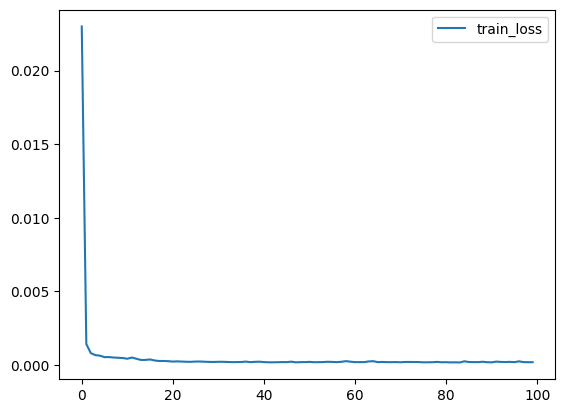

In [209]:
import matplotlib.pyplot as plt
import pandas as pd

# 학습 곡선 시각화
plt.figure(figsize=(6, 4))
loss_data = pd.DataFrame(loss_history)
loss_data.plot()

In [217]:
train_set_ori.iloc[:,-1]

Date
2020-02-19    185525.183377
2020-02-20    187005.441324
2020-02-21    185031.765336
2020-02-24    183058.082159
2020-02-25    181577.831365
                  ...      
2023-08-01    231647.692295
2023-08-02    234138.521635
2023-08-03    225669.685153
2023-08-04    229655.010591
2023-08-07    225669.686134
Name: (Open, 035420.KS), Length: 857, dtype: float64

### 평가

0.0
(368,)
(368, 1)
torch.Size([368, 1])


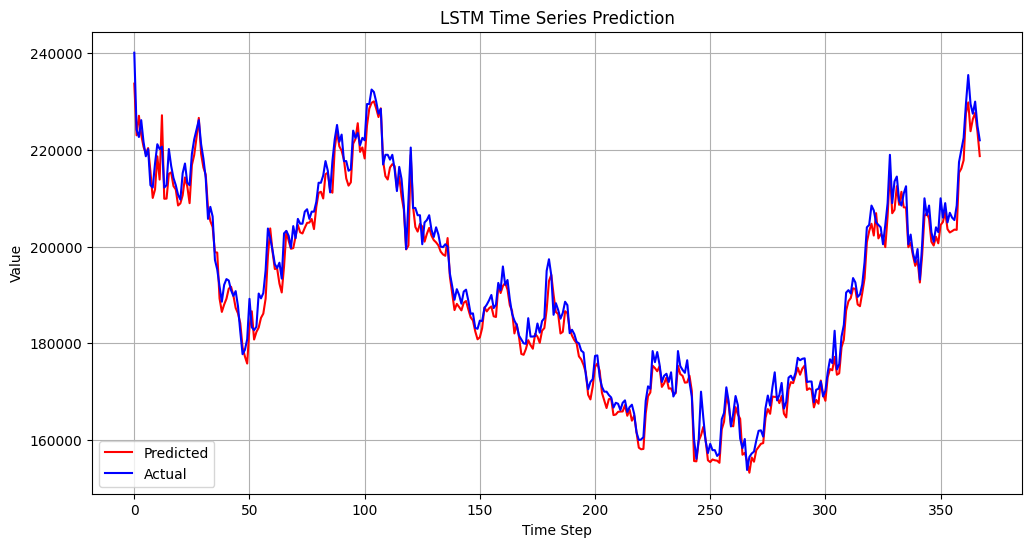

In [219]:
# 예측
model.to(device)
model.eval()

loss_test = 0.0
pred_history = []
for x_tmp in testX_ts:
    with torch.no_grad():
        x_unsqeeze = x_tmp.unsqueeze(dim=0).to(device)
        pred = model(x_unsqeeze)
        pred_history.append(pred[0].item())
    
print((loss_test / len(test_dataset)))
print(np.array(pred_history).shape)
print(np.array(pred_history).reshape(-1, 1).shape)
print(testY_ts.shape)

# 스케일링 복원 (Inverse Transform)
scaler_y = MinMaxScaler()
scaler_y.fit(train_set_ori.iloc[:, -1].values.reshape(-1, 1))  # 올바른 피팅

pred_restored = scaler_y.inverse_transform(np.array(pred_history).reshape(-1,1))  # 예측값 복원
actualY = scaler_y.inverse_transform(testY.reshape(-1, 1))  # 실제값 복원

# 예측값과 실제값 시각화
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(pred_restored)), pred_restored, label="Predicted", color="red")
plt.plot(np.arange(len(actualY)), actualY, label="Actual", color="blue")

plt.title("LSTM Time Series Prediction")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


torch.Size([7, 4])
tensor([[[0.2247, 0.2057, 0.2298, 0.2257],
         [0.2765, 0.2552, 0.2504, 0.2352],
         [0.2960, 0.2920, 0.3076, 0.2921],
         [0.2782, 0.2776, 0.2933, 0.3000],
         [0.2636, 0.2536, 0.2711, 0.2732],
         [0.2652, 0.2792, 0.2743, 0.2858],
         [0.3008, 0.2983, 0.2902, 0.2732]]])
torch.Size([7, 4])
tensor([[[0.2765, 0.2552, 0.2504, 0.2352],
         [0.2960, 0.2920, 0.3076, 0.2921],
         [0.2782, 0.2776, 0.2933, 0.3000],
         [0.2636, 0.2536, 0.2711, 0.2732],
         [0.2652, 0.2792, 0.2743, 0.2858],
         [0.3008, 0.2983, 0.2902, 0.2732],
         [0.2636, 0.2983, 0.2838, 0.3190]]])
torch.Size([7, 4])
tensor([[[0.2960, 0.2920, 0.3076, 0.2921],
         [0.2782, 0.2776, 0.2933, 0.3000],
         [0.2636, 0.2536, 0.2711, 0.2732],
         [0.2652, 0.2792, 0.2743, 0.2858],
         [0.3008, 0.2983, 0.2902, 0.2732],
         [0.2636, 0.2983, 0.2838, 0.3190],
         [0.2782, 0.2696, 0.2870, 0.2684]]])
torch.Size([7, 4])
tensor([[[0.278

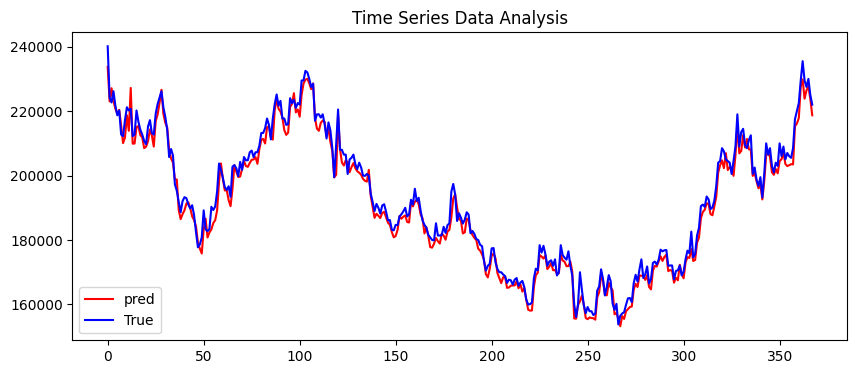

In [220]:
## 예측값 그려보기
model = model.to("cpu")
model.eval()

pred_history = []
for i in range(len(testX_ts)):

    with torch.no_grad():
        model.reset_hidden_state()

        # 예측
        print(testX_ts[i].shape)
        x_unsqeeze = testX_ts[i].unsqueeze(dim=0)
        print(x_unsqeeze)
        pred = model(x_unsqeeze)
        # print(f"TestX Tensor Shape: {testX_ts[i].shape}")
        # print(f"TestX Tensor Unsqueeze Shape: {testX_ts[i].unsqueeze(dim=0).shape}")
        # print(f"Pred: {pred}")
        # print(f"Pred 값 추출: {pred[0].item()}")

        # 저장
        pred_history.append(pred[0].item())

# scaler 되돌리기
scaler_y = MinMaxScaler()
scaler_y.fit(train_set_ori.iloc[:, -1].values.reshape(-1, 1))  # 올바른 피팅

print(f"pred의 shape: {np.array(pred_history).shape}")
print(f"pred의 Reshape(-1,1) 후 shape: {np.array(pred_history).reshape(-1,1).shape}")
print(f"testY_ts의 Shape: {testY_ts.shape}")
pred_inverse = scaler_y.inverse_transform(np.array(pred_history).reshape(-1,1))
testY_inverse = scaler_y.inverse_transform(testY_ts)


plt.figure(figsize=(10,4))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label="pred", color="r")
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label="True", color="b")
plt.legend()
plt.title("Time Series Data Analysis")
plt.show()